In [1]:
import featuretools as ft
from featuretools.selection import remove_low_information_features
from featuretools.primitives import Day, Weekend, Weekday, Percentile
import pandas as pd
import numpy as np
import utils_backblaze as utils
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from dldb import DLDB
import os
ft.__version__

/Users/bschreck/miniconda3/envs/py3default/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'0.1.19'

# DLDB: Using DFS for Smaller, Easier to Train Recurrent Neural Networks


### Brief DFS primer
Deep Feature Synthesis (DFS) works on time-varying, transactional-level data to generate powerful, interpretable features for machine learning. Raw data consists of many tables, with some columns acting as links between tables. We want to produce a fixed-size feature vector for each row of one of these tables, but taking advantage of the data contained in the other tables. DFS generates these feature vectors by applying many statistical functions, called primitives, across tables. And importantly, it generates these features at specific moments in time, taking precautions to only use data from before the desired time.

For instance, the data we will use in this notebook contains a table with a row for each Instacart user, and several other tables about their shopping behavior. DFS can apply the "sum" primitive to the dollar amount of each order per user, producing a feature for "the total amount spent on Instacart per user". Adding a *cutoff time* of March 1, 2015, the feature becomes the "total amount spent on Instacart per user before March 1, 2015". DFS can also combine several primitives, allowing it to form features like the "standard deviation of the number of items in each user's previous orders".

For a more in depth explanation of DFS, we encourage you to check out this [blog post](https://www.featurelabs.com/blog/deep-feature-synthesis/) and [this page](https://docs.featuretools.com/automated_feature_engineering/afe.html) in the Featuretools documentation.

### TDFS
DFS as described produces a 2-dimensional feature matrix that can be used for classic machine learning techniques, such as SVM or Random Forest. These techniques need a fixed-size feature matrix where any time-dependence is summarized into historical statistics (e.g. Number of items a customer purchased in the past 30 days).

We can take more explicit advantage of the time-dimension in this type of data using Recurrent Neural Networks. RNNs take in sequences of features, where the 3rd dimension in our case would represent time. Since RNNs learn high-level features on their own, the usual approach when using multiple tables is just to join all of them together and use the raw values. We will show that approach as a baseline here.

Instead, we can use DFS to produce high-level features at different points in time, and then learn from these sequences of features, rather than raw data. We call this variant TDFS, for timestamped DFS. Combining TDFS with RNNs essentially encodes prior human intuition and assumptions about relevant data transformations into the problem before letting the deep learning do its thing. Because the net doesn't have to learn every feature from scratch, we may be able to reduce training time, use a simpler net, not have to tweak as many hyperparameters, use less data, or boost performance. In this notebook, we will show that with a relatively simple network we can achieve pretty good AUC with the DFS features before the raw data network learns much of anything.

We'll try it on Instacart data, solving the same problem as this [previous Featuretools demo](https://github.com/Featuretools/predict_next_purchase), which used a Random Forest to predict whether a customer will buy a banana in their next Instacart order.

### Brief DFS Primer

The DFS algorithm is a way to build high-level features from raw time-varying 

For a more in depth explanation, we encourage you to check out this [blog post](https://www.featurelabs.com/blog/deep-feature-synthesis/) and [this page](https://docs.featuretools.com/automated_feature_engineering/afe.html) in the Featuretools documentation.

## DLDB Library

[DLDB](https://github.com/HDI-Project/DL-DB) is a utility library for building recurrent neural networks from a feature matrix with multiple cutoff times per instance. Internally, it uses the [Keras](keras.io) library (which in turn uses [Tensor Flow](tensorflow.org)). 

It works by first imputing and scaling a sequence feature matrix (the result of calling `tdfs()`), and then separating the numeric features from the categoricals. Each categorical feature is mapped to a Keras Embedding layer in order to transform it into a dense, numeric vector. Then these embeddings are concatenated with the numeric features and fed into several recurrent layers (specified in hyperparameters) and several feed-forward layers (also specified in hyperparameters). It also includes an optional 1-D convolutional layer that will be applied before the recurrent layers. All the network layers, including the categorical embeddings, are trained end-to-end using any gradient update methods available in Keras.

We packaged DL-DB into a Python library that can be installed via pip:
    
```
pip install dldb
```

This library includes both a class to build these recurrent neural network models as well as the `tdfs()` function that creates time-series features as input.

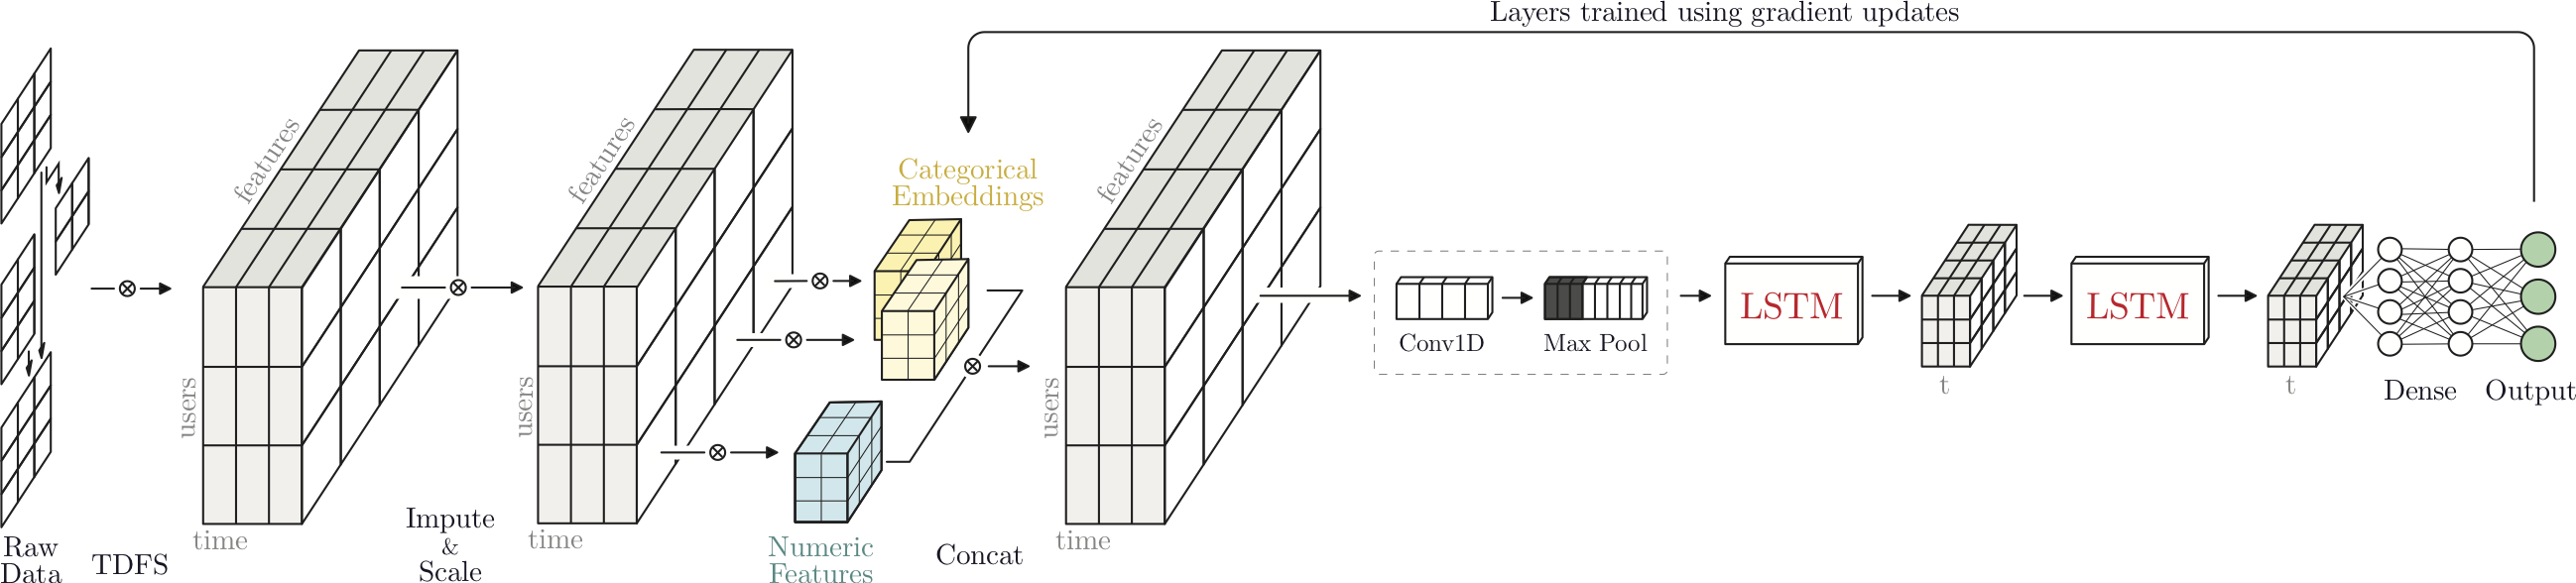

## 1. Load in the data

The data is partitioned into chunks based on `user_id`, and loaded into the Featuretools Entityset format. See [the original demo](https://github.com/Featuretools/predict_next_purchase) for more explananation about how the data is partitioned and the Entityset is formed.

In [40]:
data_dir = '/Users/bschreck/Google Drive File Stream/My Drive/Feature Labs Shared/EntitySets/entitysets/backblaze_harddrive/data'
df = utils.load_data_as_dataframe(data_dir=data_dir, csv_glob='*.csv')

In [41]:
def upsample(df):
    if df['failure'].any():
        return df
    elif np.random.sample() < 0.01:
        return df
    else:
        return pd.DataFrame()
df = df.groupby('serial_number').apply(upsample)
es = utils.load_entityset_from_dataframe(df)
es

Entityset: BackBlaze
  Entities:
    SMART_observations [Rows: 70597, Columns: 94]
    HDD [Rows: 1232, Columns: 4]
    models [Rows: 26, Columns: 1]
  Relationships:
    SMART_observations.serial_number -> HDD.serial_number
    HDD.model -> models.model

## 2. Construct labels

This utility function picks out a window of time, and finds which users bought bananas. Again, more explanation in [the original demo](https://github.com/Featuretools/predict_next_purchase).

In [78]:
training_window = "20 days"
lead = pd.Timedelta('1 day')
prediction_window = pd.Timedelta('25 days')
min_training_data = pd.Timedelta('5 days')

In [44]:
labels = utils.create_labels(es,
                             lead,
                             min_training_data)

Creating labels...: 100%|██████████| 1233/1233 [00:02<00:00, 510.58it/s]


In [45]:
labels.value_counts()

False    910
True     282
Name: label, dtype: int64

## Create time-stamped feature matrix using DFS

Here is where things start to get interesting. We use the [`tdfs` function in DLDB](https://github.com/HDI-Project/DL-DB/blob/master/dldb/tdfs.py) to produce a feature matrix with several rows per user. It works by adding additional cutoff times in the past to each `(user_id, cutoff_time)` provided in `label_times`.

This function has a few different ways of selecting these additional cutoff times. Here, we provide `window_size='3d'` and `start=cutoff_time - training_window`, which will go back in time in increments of 3 days until 60 days before the cutoff time of March 1st. This produces a sequence of 20 cutoff times per user.

We could have also specified `num_windows=20` and `window_size=3d` to produce the same result.

The rest of the arguments are standard DFS arguments. For an overview of DFS, check out the [Featuretools documentation](https://docs.featuretools.com/automated_feature_engineering/afe.html).

In [74]:
temporal_cutoffs = ft.make_temporal_cutoffs(instance_ids=labels.index.get_level_values('serial_number'),
                                            cutoffs=labels.index.get_level_values('cutoff'),
                                            window_size='1d',
                                            num_windows=10)

In [75]:
temporal_cutoffs.shape

(11920, 2)

In [79]:
# from featuretools.primitives import Days
# trans_primitives = [Day, Days]
# fm, fl = ft.dfs(entityset=es,
#                 target_entity="HDD",
#                 cutoff_time=temporal_cutoffs,
#                 cutoff_time_in_index=True,
#                 trans_primitives=trans_primitives,
#                 training_window=training_window,
#                 max_depth=2,
#                 verbose=True)
from featuretools.primitives import Days, Last
trans_primitives = []
fm, fl = ft.dfs(entityset=es,
                target_entity="HDD",
                cutoff_time=temporal_cutoffs,
                cutoff_time_in_index=True,
                agg_primitives=[Last],
                trans_primitives=trans_primitives,
                training_window=training_window,
                max_depth=1,
                verbose=True)

Built 92 features

Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/11 chunks
Elapsed: 00:03 | Remaining: 00:34 | Progress:   9%|▉         | Calculated: 1/11 chunks
Elapsed: 00:06 | Remaining: 00:29 | Progress:  18%|█▊        | Calculated: 2/11 chunks
Elapsed: 00:09 | Remaining: 00:24 | Progress:  27%|██▋       | Calculated: 3/11 chunks
Elapsed: 00:12 | Remaining: 00:21 | Progress:  36%|███▋      | Calculated: 4/11 chunks
Elapsed: 00:15 | Remaining: 00:18 | Progress:  45%|████▌     | Calculated: 5/11 chunks
Elapsed: 00:18 | Remaining: 00:15 | Progress:  55%|█████▍    | Calculated: 6/11 chunks
Elapsed: 00:21 | Remaining: 00:12 | Progress:  64%|██████▎   | Calculated: 7/11 chunks
Elapsed: 00:24 | Remaining: 00:09 | Progress:  73%|███████▎  | Calculated: 8/11 chunks
Elapsed: 00:28 | Remaining: 00:06 | Progress:  82%|████████▏ | Calculated: 9/11 chunks
Elapsed: 00:32 | Remaining: 00:03 | Progress:  91%|█████████ | Calculated: 10/11 chunks
Elapsed: 00:32 | Remaining:

In [80]:
fm, fl = remove_low_information_features(fm, fl)

In [81]:
fm = fm.swaplevel(i=1, j=0).sort_index()

In [82]:
fm.head()

model  capacity_bytes  \
time       serial_number                          
2016-12-29 Z1Z0541W         NaN             NaN   
2016-12-30 MJ1323YNG1LE6C   NaN             NaN   
           PL1311LAG25KLA   NaN             NaN   
           PL1311LAG3DW0H   NaN             NaN   
           PL1331LAGSP4WH   NaN             NaN   

                           LAST(SMART_observations.smart_10_normalized)  \
time       serial_number                                                  
2016-12-29 Z1Z0541W                                                 NaN   
2016-12-30 MJ1323YNG1LE6C                                           NaN   
           PL1311LAG25KLA                                           NaN   
           PL1311LAG3DW0H                                           NaN   
           PL1331LAGSP4WH                                           NaN   

                           LAST(SMART_observations.smart_10_raw)  \
time       serial_number                                           
2016-12-29 Z1Z0541W                                          NaN   
2016-12-30 MJ1323YNG1LE6C                                    NaN   
           PL1311LAG25KLA                                    NaN   
           PL1311LAG3DW0H                                    NaN   
           PL1331LAGSP4WH                                    NaN   

                           LAST(SMART_observations.smart_11_normalized)  \
time       serial_number                                                  
2016-12-29 Z1Z0541W                                                 NaN   
2016-12-30 MJ1323YNG1LE6C                                           NaN   
           PL1311LAG25KLA                                           NaN   
           PL1311LAG3DW0H                                           NaN   
           PL1331LAGSP4WH                                           NaN   

                           LAST(SMART_observations.smart_11_raw)  \
time       serial_number                                           
2016-12-29 Z1Z0541W                                          NaN   
2016-12-30 MJ1323YNG1LE6C                                    NaN   
           PL1311LAG25KLA                                    NaN   
           PL1311LAG3DW0H                                    NaN   
           PL1331LAGSP4WH                                    NaN   

                           LAST(SMART_observations.smart_12_normalized)  \
time       serial_number                                                  
2016-12-29 Z1Z0541W                                                 NaN   
2016-12-30 MJ1323YNG1LE6C                                           NaN   
           PL1311LAG25KLA                                           NaN   
           PL1311LAG3DW0H                                           NaN   
           PL1331LAGSP4WH                                           NaN   

                           LAST(SMART_observations.smart_12_raw)  \
time       serial_number                                           
2016-12-29 Z1Z0541W                                          NaN   
2016-12-30 MJ1323YNG1LE6C                                    NaN   
           PL1311LAG25KLA                                    NaN   
           PL1311LAG3DW0H                                    NaN   
           PL1331LAGSP4WH                                    NaN   

                           LAST(SMART_observations.smart_183_normalized)  \
time       serial_number                                                   
2016-12-29 Z1Z0541W                                                  NaN   
2016-12-30 MJ1323YNG1LE6C                                            NaN   
           PL1311LAG25KLA                                            NaN   
           PL1311LAG3DW0H                                            NaN   
           PL1331LAGSP4WH                                            NaN   

                           LAST(SMART_observations.smart_183_raw)  \
time       serial_number                                 

In [ ]:
# Can save/restore our work without having to recompute feature matrix
# fm.to_csv("backblaze_ftens_high_info.csv")
# ft.save_features(fl, 'backblaze_high_info_fl.p')
# labels.to_frame().to_csv("backblaze_labels.csv")

# fm = pd.read_csv('backblaze_ftens_high_info.csv', parse_dates=['time'], index_col=['time', 'serial_number'])
# labels = pd.read_csv('backblaze_labels.csv', parse_dates=['cutoff'], index_col=['cutoff', 'serial_number'])['label']
# fl = ft.load_features('backblaze_high_info_fl.p', es)

### Create Baseline Input Data

This "feature_matrix" is created by joining all entities in the data together into one dataframe.
Just like the feature matrix created from `tdfs`, we make sure to cutoff the data at the cutoff time, and only use 60 days of data.

In [65]:
cutoffs = labels.reset_index('cutoff').reset_index('serial_number')[['serial_number', 'cutoff']]
cutoff_raw = utils.cutoff_raw_data(df, cutoffs, training_window)

## Initialize DLDB with desired hyperparameters

In this example, we use 2 fairly small [LSTM](https://keras.io/layers/recurrent/) layers and 2 feed-forward layers (called "Dense layers" in Keras/Tensor Flow terminology). DLDB has an extremely simple API, and exposes a large number of hyperparameters, so is amenable to hyperparameter optimization algorithms.

Each categorical feature will be mapped to a 12-dimensional embedding, with a maximum of 20 unique categorical values (the top 20 most frequent values will be chosen, and the rest will be converted to a single token).

In [83]:
dl_model = DLDB(
    regression=False,
    classes=[False, True],
    recurrent_layer_sizes=(32, 32),
    dense_layer_sizes=(32, 16),
    dropout_fraction=0.2,
    recurrent_dropout_fraction=0.2,
    categorical_embedding_size=12,
    categorical_max_vocab=20)

### Compile the network

**Note** Doing this step outside of the cross-validation loop is *slightly* cheating because we give it all the categorical values ahead of time. It most likely won't make a difference, and this step takes some time.

Feel free to move it inside of the cross-validation for loop and see how much the results change.

In [84]:
dl_model.compile(fm, fl=fl)

## Train the model and test using cross-validation

We use a `batch_size` of 128 (for each gradient update step) and train over 3 passes of the dataset (epochs).

In [85]:
n_splits=20
splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

In [86]:
cv_score = []

for train_test_index in splitter.split(labels, labels):
    train_labels = labels.reset_index('cutoff', drop=True).iloc[train_test_index[0]]
    test_labels = labels.reset_index('cutoff', drop=True).iloc[train_test_index[1]]
    train_fm = fm.reset_index('time', drop=True).loc[train_labels.index, :]
    test_fm = fm.reset_index('time', drop=True).loc[test_labels.index, :]

    dl_model.fit(
        train_fm, train_labels,
        # Provide this many samples to the network at a time
        batch_size=32,
        epochs=3,
        # After each epoch, test on a held out 10% validation set
        validation_split=0.1)
    
    predictions = dl_model.predict(test_fm)
    score = roc_auc_score(test_labels, predictions)
    print("cv score: ", score)
    cv_score.append(score)
mean_score = np.mean(cv_score)
stderr = 2 * (np.std(cv_score) / np.sqrt(n_splits))

print("AUC %.2f +/- %.2f" % (mean_score, stderr))

Transforming input tensor into numeric sequences
Fitting Keras model
Train on 1017 samples, validate on 114 samples
Epoch 1/3
1017/1017 [==============================] - 21s 20ms/step - loss: 0.6032 - val_loss: 0.4284
Epoch 2/3
1017/1017 [==============================] - 17s 17ms/step - loss: 0.5774 - val_loss: 0.3877
Epoch 3/3
1017/1017 [==============================] - 18s 17ms/step - loss: 0.5654 - val_loss: 0.4132
Transforming input tensor into numeric sequences
Predicting using Keras model
Transforming outputs
cv score:  0.41739130434782606
Transforming input tensor into numeric sequences
Fitting Keras model
Train on 1017 samples, validate on 114 samples
Epoch 1/3
1017/1017 [==============================] - 21s 20ms/step - loss: 0.6078 - val_loss: 0.4320
Epoch 2/3
1017/1017 [==============================] - 17s 16ms/step - loss: 0.5872 - val_loss: 0.4408
Epoch 3/3
1017/1017 [==============================] - 16s 16ms/step - loss: 0.5794 - val_loss: 0.4266
Transforming input t

KeyboardInterrupt: 

## Train the baseline model over raw data and test using cross-validation

We use the same parameters here. Note that we tell DL-DB explicitly what feature names are categorical.

In [68]:
categorical_feature_names = ["model"]
dl_model.compile(cutoff_raw, categorical_feature_names=categorical_feature_names)

In [73]:
cv_score = []

for i, train_test_index in enumerate(splitter.split(labels, labels)):
    train_labels = labels.reset_index('cutoff', drop=True).iloc[train_test_index[0]]
    test_labels = labels.reset_index('cutoff', drop=True).iloc[train_test_index[1]]
    train_fm = cutoff_raw.reset_index('date', drop=True).loc[train_labels.index, :]
    test_fm = cutoff_raw.reset_index('date', drop=True).loc[test_labels.index, :]

    dl_model.fit(
        train_fm, train_labels,
        # Provide this many samples to the network at a time
        batch_size=128,
        epochs=3,
        # After each epoch, test on a held out 10% validation set
        validation_split=0.1)
    
    predictions = dl_model.predict(test_fm)
    score = roc_auc_score(test_labels, predictions)
    print("cv score: ", score)
    cv_score.append(score)

mean_score = np.mean(cv_score)
stderr = 2 * (np.std(cv_score) / np.sqrt(n_splits))

print("AUC %.2f +/- %.2f" % (mean_score, stderr))

Transforming input tensor into numeric sequences
Fitting Keras model
Train on 1017 samples, validate on 114 samples
Epoch 1/3
1017/1017 [==============================] - 10s 10ms/step - loss: 0.6322 - val_loss: 0.4311
Epoch 2/3
1017/1017 [==============================] - 7s 7ms/step - loss: 0.5857 - val_loss: 0.3847
Epoch 3/3
1017/1017 [==============================] - 7s 7ms/step - loss: 0.5721 - val_loss: 0.4117
Transforming input tensor into numeric sequences
Predicting using Keras model
Transforming outputs
cv score:  0.5297101449275362
Transforming input tensor into numeric sequences
Fitting Keras model
Train on 1017 samples, validate on 114 samples
Epoch 1/3
1017/1017 [==============================] - 10s 10ms/step - loss: 0.6547 - val_loss: 0.4780
Epoch 2/3
1017/1017 [==============================] - 7s 7ms/step - loss: 0.5912 - val_loss: 0.4169
Epoch 3/3
1017/1017 [==============================] - 7s 7ms/step - loss: 0.5900 - val_loss: 0.4179
Transforming input tensor int

KeyboardInterrupt: 

### Scaling to the full dataset

We used a small, single partition here. Typically, deep learning methods start to shine as the data gets bigger and bigger. Here we've shown that we only need a small fraction of the data to learn a very accurate model using DFS combined with recurrent neural networks.

The full dataset is over 100x bigger, with over 33 million rows. We tested this same model, but with a larger network, on the full dataset with and without DFS (using the GPU-version of Tensor Flow). With a dataset of that size, the performances of these two models start to converge to 0.9 AUC. We hypothesize, but did not test, that increasing the number of time windows in the `tdfs()` call would boost the DFS version past the denormalized, raw data version. We encourage you to try it out yourself!

### Conclusions

The model using DFS features scored over 30% better AUC than the raw data model for the same parameters.

Try increasing the number of epochs in the raw data model- eventually you will end up with similar scores as the DFS model. I found that increasing from 3 to 7 epochs increases the raw data score from .53 to .66.

This is an interesting result, and hints at the idea that using good features to start out with can reduce the training time of deep learning models.

There are many more ideas we can test here (both on the single partition, and on the full dataset):
 * What happens as we increase the complexity of the network?
 * How about increasing the number of time windows in `tdfs`?
 * Increasing the number of `dfs` features?
 * How many rounds of hyperparameter optimization do we have to do to achieve the same result?
 * Is it possible to visualize the effect of the input features on the LSTM network? This is a hard problem in deep learning in general